In [291]:
import string

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import LinearSVC 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# Preprocessing

In [292]:
def cleanDf(df):
    for i in range(2):
        for i,question in enumerate(df['Question']):
            df['Question'][i] = cleanText(question)
    return df
def cleanText(text):
    words_token = nltk.word_tokenize(text)
    cleaned_tokens = cleanTokens(words_token)
    text = ' '.join(cleaned_tokens)
    return text
def cleanTokens(tokens):
    # remove stopwords, punctuation, numbers, single/double character, Lemmatization
    wnl = WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w.lower() for w in tokens if w.lower() not in stopwords]
    content = [c for c in content if c not in list(string.punctuation)]
    content = [c for c in content if not c.isdigit()]
    content = [c for c in content if len(c)>2]
    content = [wnl.lemmatize(c) for c in content]
    return content

In [293]:
df = pd.read_excel ('data.xlsx')
df=cleanDf(df)

In [294]:
# shuffle
df=df.sample(frac=1)
# split train set and test set
X = df['Question']
Y = df['Label']

# Word2Vec + Svm

In [295]:
def KFoldCrossValModels(models, X, Y, fold=10):
    figureSize = (13,8.27)
    sns.set(rc={'figure.figsize':figureSize})
    cv_df = pd.DataFrame(index=range(fold * len(models))) 
    entries = []
    for model in models: 
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=fold) 
        for fold_idx, accuracy in enumerate(accuracies): 
            entries.append((model_name, fold_idx, accuracy)) 
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy']) 
    sns.boxplot(x='model_name', y='accuracy', data=cv_df) 
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
    kFoldMean = cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)
    return kFoldMean

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          DecisionTreeClassifier(),
          MultinomialNB(),
          MLPClassifier(),
          KNeighborsClassifier(),
          LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto')] 

w2vModels = [model for model in models if model.__class__.__name__!='MultinomialNB']
tfidfModels = models.copy()

C:\Users\sysal\.conda\envs\comp4211\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


model_name
DecisionTreeClassifier    0.538312
RandomForestClassifier    0.497341
KNeighborsClassifier      0.353435
LinearSVC                 0.344768
MLPClassifier             0.329101
LogisticRegression        0.324449
Name: accuracy, dtype: float64

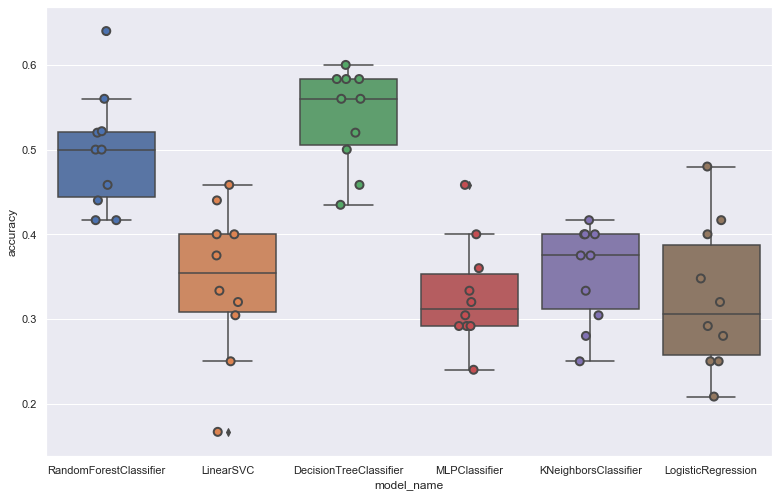

In [296]:
# get each question vector
def get_sent_vec(size,sent,model):
    vec = np.zeros(size).reshape(1,size)
    count = 0
    for word in sent:
        try:
            vec += model[word].reshape(1,size)
            count += 1
        except:
            continue
    if count != 0:
        vec /= count
    return vec
def getSentVecFromDf(X):
    word2VecModel = Word2Vec(X,sg=0,hs=1,min_count=1,window=5,size=300)
    sentVec = np.concatenate([get_sent_vec(300,sent,word2VecModel) for sent in X])
    return sentVec

w2vKFoldMean = KFoldCrossValModels(w2vModels, getSentVecFromDf(X), Y)
w2vKFoldMean

In [301]:
w2vKFoldMean

model_name
DecisionTreeClassifier    0.538312
RandomForestClassifier    0.497341
KNeighborsClassifier      0.353435
LinearSVC                 0.344768
MLPClassifier             0.329101
LogisticRegression        0.324449
Name: accuracy, dtype: float64

# TFIDF + SVM

# TFIDF + Models(RandomForest, SVM, Naive Bayes, Logistic Regression)

In [297]:
# Caluculate tfidf vecotrs 
tfidfVector = TfidfVectorizer()
tf_data = tfidfVector.fit_transform(X)

# vectorizedX_test = tfidfVector.transform(x_test)
# svm_train('TFIDF Svm',tf_data,y_train,vectorizedX_test,y_test)

C:\Users\sysal\.conda\envs\comp4211\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\sysal\.conda\envs\comp4211\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\sysal\.conda\envs\comp4211\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\sysal\.conda\envs\comp4211\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn'

model_name
LogisticRegression        0.844138
LinearSVC                 0.840638
MLPClassifier             0.828123
KNeighborsClassifier      0.815775
MultinomialNB             0.811457
DecisionTreeClassifier    0.766623
RandomForestClassifier    0.692428
Name: accuracy, dtype: float64

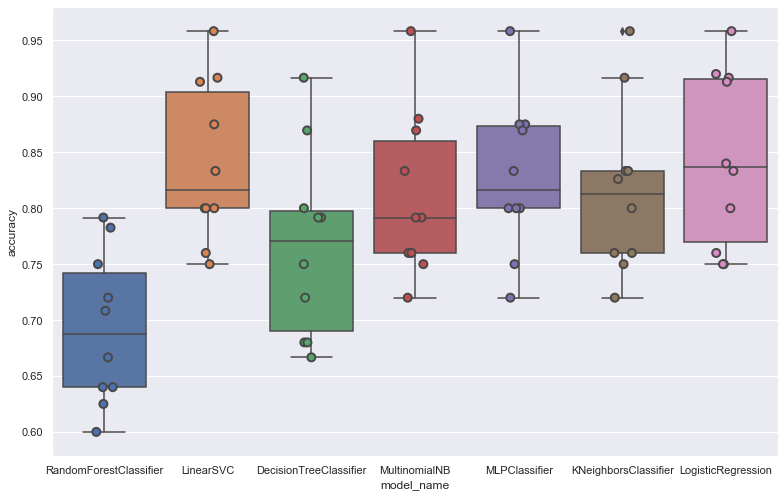

In [298]:
tfidfKfoldMean = KFoldCrossValModels(models, tf_data, Y)
tfidfKfoldMean